In [11]:
# by using this below code, we dont need to download the kaggle dataset , we can directly use from kaggle
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist", quiet=True)

Skipping, found downloaded files in "./fashionmnist" (use force=True to force download)


# This will be our architectural flow of CNN -

In [1]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

In [2]:
# every run will give (almost) the same results
torch.manual_seed(42) # 42 random numbers

# check for GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
df = pd.read_csv("/content/fashionmnist/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0],test_size=0.2,random_state=42)

In [5]:
# scaling the training datset (to keep all the values in the range of 0 and 1)
X_train = X_train/255.0
X_test = X_test/255.0

In [6]:
class CustomDataset(Dataset):
  def __init__(self,input_data,output_data):
    self.input_data = torch.tensor(input_data.to_numpy(),dtype=torch.float32).reshape(-1,1,28,28)
    # .reshape(-1,1,28,28) --> it is .reshape(batch_size,channels,height,width) --> (-1) because currently we dont know batch size, (1) means grayscale image(black and white), if it was 3 then RGB image
    # here we change the input_data dtype to numpy array and then changed the dtype to PyTorch Tensors
    # as directly from X_train or X_test we cant convert it to tensors.
    self.output_data = torch.tensor(output_data.to_numpy(),dtype=torch.long)
  def __len__(self):
    return len(self.input_data)
  def __getitem__(self,index):
    return self.input_data[index],self.output_data[index]

# we now need to create object of this class and it will automatically call the constructor that is __init__ method
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

# now we need to call the DataLoader class --> which will create mini batches (in our case we took 32 batches )-> like this --> DataLoader(Dataset)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False) # because when we predict output , we dont want to shuffle the data

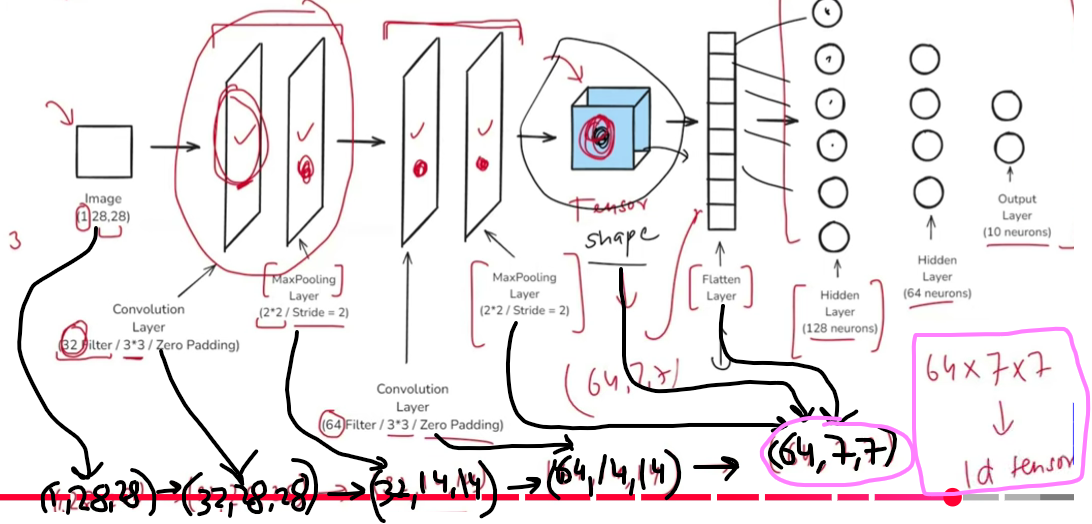

In [7]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        # in CNN we have 2 parts -
        # 1- feature_extraction --> input_image - {convolution - pooling} in pairs - flatten the image
        # 2- classification --> flattened image in 1d - output
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),  # input_features= no of channels we are passing ,
            # in our case its an grayscale image so 1 ( if it was RGB image then 3), padding='same' means image size is not reduced after change also ,
            # kernel_size = 3 means (3*3), 32 is filter size of (3*3) kernel
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), # this means we have kernel of size (2*2) and when we put it on an image, after calculations , it will shift to +2 places on the image

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),  # 32 = total no of channels that we got from previous pair, 64 is filter size of (3*3) kernel ,padding='same' means image size is not reduced after change also, kernel_size = 3 means (3*3)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classification = nn.Sequential( # here we have flatten layer -> hidden layer-1(128 neurons) --> hidden layer-2(64 neurons) --> output layer(10 neurons)
            nn.Flatten(),  # flatten layer

            nn.Linear(64*7*7, 128),   # 64*7*7 is the tensor shape
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10) # output layer
        )

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.classification(x)
        return x

model = MyNN(1) # this 1 is the input feature
model.to(device)

MyNN(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [8]:
learning_rate = 0.01
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [9]:
# training loop

for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    # forward pass
    outputs = model(batch_features)
    # calculate loss
    loss = criterion(outputs, batch_labels)
    # back pass
    optimizer.zero_grad()
    loss.backward()
    # update grads
    optimizer.step()
    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 0.6453360715607802
Epoch: 2 , Loss: 0.3859660826325417
Epoch: 3 , Loss: 0.32741353537887335
Epoch: 4 , Loss: 0.2908012580871582
Epoch: 5 , Loss: 0.26928483178218204
Epoch: 6 , Loss: 0.2472891476129492
Epoch: 7 , Loss: 0.23315572207669416
Epoch: 8 , Loss: 0.21239412373428543
Epoch: 9 , Loss: 0.20190196732183296
Epoch: 10 , Loss: 0.19086048908159137
Epoch: 11 , Loss: 0.1755717468926062
Epoch: 12 , Loss: 0.16822185139792661
Epoch: 13 , Loss: 0.1565520987091586
Epoch: 14 , Loss: 0.14846935041310885
Epoch: 15 , Loss: 0.14460837068532903
Epoch: 16 , Loss: 0.1324991537615036
Epoch: 17 , Loss: 0.12582528460553538
Epoch: 18 , Loss: 0.12148053987479458
Epoch: 19 , Loss: 0.1133649807345743
Epoch: 20 , Loss: 0.10751275035707901
Epoch: 21 , Loss: 0.10653987129451707
Epoch: 22 , Loss: 0.095385051287245
Epoch: 23 , Loss: 0.09372510337503627
Epoch: 24 , Loss: 0.08458741272597885
Epoch: 25 , Loss: 0.08385746959763735
Epoch: 26 , Loss: 0.08143842628528364
Epoch: 27 , Loss: 0.07987361818

In [10]:
model.eval()

MyNN(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [11]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9263333333333333


In [12]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:
    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model(batch_features)
    _, predicted = torch.max(outputs, 1)
    total = total + batch_labels.shape[0]
    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total) # here overfitting is happening as we are using small dataset

1.0
